In [39]:
from cropclass import tsmask
import gippy
import gippy.algorithms as alg
import numpy as np
import pandas as pd
import os
import re

# For modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing
import time

# PLotting
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches

In [3]:
# Rasterize land cover polygons
shp = '/home/ec2-user/ethiopia_luc/Training_polygons/landuse.shp'

out = '/home/ec2-user/ethiopia_luc/lc_mask/land-cover-mask.tif'

ref = '/home/ec2-user/ethiopia_luc/scenes/Ethiopia_2017_Q1_19.tif'

# Rasterize
lc_mask = tsmask.rasterize(shapefile=shp, outimg=out, refimg=ref, attribute='woreda_id')

Class 0 contains 84493768 pixels
Class 1 contains 422 pixels
Class 2 contains 72493 pixels
Class 3 contains 66742 pixels


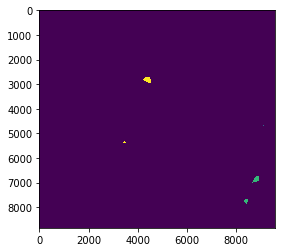

In [4]:
# Confirm that shapefile was rasterized correctly 
# 1 = urban, 2 = water, 3 = veg
tsmask.check_rasterize(out)

In [132]:
def extract_dataset(scenes, lc_raster, dates, lc_dict, nodata):
    """Extract band values (band/date) at training data locations
    
    Parameters
    ----------
        scenes (str): file path to folder containing multi-band geotiff images; single scene, multiple dates 
        lc_raster (str): file path to rasterized land cover layer (e.g. output of `satTS.cropclass rasterize`)
        dates (list): list of dates corresponding to files in `scenes` 
        lc_dict (dict): keys = numeric values burned into lc_raster; values = assocated land cover class
        nodata: nodata value (supplied to gippy.Geoimage)
        
    Returns
    -------
        dataset (pd.DataFrame): long-form data frame with feature, value, and date columns for each land-cover sample
    """
    
    land_cover = gippy.GeoImage.open(filenames=[lc_raster], bandnames=(['land_cover']), nodata=nodata)
    lc = land_cover.read()

    # 0 is nodata class
    lc_classes = np.unique(lc[lc != nodata])

    # Add NDVI and BSI bands for all scenes
    scene_df = []
    for cnt, scene in enumerate(scenes):
        bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']

        # Add NDVI for each scene
        img = gippy.GeoImage.open(filenames=[scene], bandnames=bands, nodata=nodata)

        ndvi = alg.indices(img, products=['ndvi'])

        img.add_band(ndvi[0])
        bands.append('ndvi')

        # Read full dataset as numpy array
        ds = img.read().astype(np.float64)
        
        # Clone image
        img = None

        # Add Bare soil index:
        swir1, red, nir, blue = ds[4], ds[2], ds[3], ds[0]

        # Calculate BSI
        bsi = ((swir1 + red) - (nir + blue)) / ((swir1 + red) + (nir + blue))
        bsi = np.expand_dims(bsi, axis=0)
        bands.append('bsi')

        # Add BSI array to dataset
        ds = np.append(ds, bsi, axis=0)

        # 2D array of features for all samples in each land cover class
        lc_dflist = []
        for c in lc_classes:

            # Array index corresponding to locations of land cover class
            w = np.argwhere(lc == c)
            ind = list(zip(w[:, 0], w[:, 1]))

            # Extract dataset for given date, land cover class
            lc_dataset = ds[:, lc == c].T

            # Convert dataset to dataframe,
            df = pd.DataFrame(lc_dataset, columns=bands)
            df['land_cover'] = lc_dict.get(c)
            df['ind'] = ind

            df = df.melt(id_vars=['land_cover', 'ind'], var_name='feature', value_name='value')

            lc_dflist.append(df)

        lc_df = pd.concat(lc_dflist)

        lc_df['date'] = dates[cnt]

        scene_df.append(lc_df)

    dataset = pd.concat(scene_df)

    return dataset

In [133]:
# Initialize arguments for extract_dataset
fp = '/home/ec2-user/ethiopia_luc/scenes'

scenes = [fp + '/' + s for s in os.listdir(fp) if not s.startswith('.')]

p = "[0-9]{4}_[Q][0-9]"
dates = [re.search(p, s)[0] for s in scenes]

lc_dict = {1: 'urban',
           2: 'water',
           3: 'vegetation'}

In [134]:
### ABOVE FUNCTION IS RESULTING IN ALL 0'S FOR NDVI - SAME FUNCTION WORKS FINE ON LOCAL MACHINE. 
### NEED TO FIGURE OUT THE PROBLEM.
### FOR NOW - IMPORT DATASET CREATED ON LOCAL MACHINE

#lc_ds = extract_dataset(scenes=scenes, lc_raster=out, dates=dates, lc_dict=lc_dict, nodata=0)

In [4]:
lc_ds = pd.read_csv('/home/ec2-user/ethiopia_luc/dataset/all-samples.csv')

In [5]:
# Wide-format for model fitting
train_ds = lc_ds.pivot_table(index=['land_cover', 'ind'], columns=['feature', 'date'], values='value').reset_index()

In [6]:
# Remove redundant bands / columns
train_ds = train_ds[train_ds.columns.drop(list(train_ds.filter(regex='red')))]
train_ds = train_ds[train_ds.columns.drop(list(train_ds.filter(regex='nir')))]
train_ds = train_ds.drop(['ind'], axis=1)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [7]:
# These bands don't seem to be contributing much
train_ds = train_ds[train_ds.columns.drop(list(train_ds.filter(regex='blue')))]
train_ds = train_ds[train_ds.columns.drop(list(train_ds.filter(regex='green')))]
#train_ds = train_ds[train_ds.columns.drop(list(train_ds.filter(regexx='swir2')))]

In [8]:
# X matrix containing to the features, and y vector containing labels
X = train_ds.iloc[:, 1:len(train_ds.columns)].astype(np.float64)
y = train_ds['land_cover']

In [9]:
# Train/Test splits
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=99)
x_train, x_test = x_train.astype(np.float64), x_test.astype(np.float64)

In [10]:
# Initialize model with 100 trees
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

# Fit model to training data
start_time = time.time()
rf = rf.fit(x_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.8639276027679443 seconds ---


In [11]:
# OOB Prediction accuracy
print('OOB prediction accuracy: {oob}%'.format(oob=rf.oob_score_ * 100))

OOB prediction accuracy: 99.9892593421347%


In [12]:
# make predictions for test data
preds = rf.predict(x_test)

In [13]:
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.99%


In [14]:
# Confusion matrix
confusion_matrix(y_test, preds)

array([[   89,     2,     0],
       [    0, 13436,     0],
       [    0,     0, 14405]])

In [15]:
# Variable importance:
feats = list(X.columns.values)

for b, imp in zip(feats, rf.feature_importances_):
    print('{b} band importance: {imp}'.format(b=b, imp=imp))

('bsi', '2017_Q1') band importance: 0.0004975081914463703
('bsi', '2017_Q2') band importance: 0.000774495036713695
('bsi', '2017_Q3') band importance: 0.00021521732847082353
('bsi', '2017_Q4') band importance: 0.0033669666045685743
('ndvi', '2017_Q1') band importance: 0.15928984141797436
('ndvi', '2017_Q2') band importance: 0.1291258280639451
('ndvi', '2017_Q3') band importance: 0.17848882386200682
('ndvi', '2017_Q4') band importance: 0.2186745238239407
('swir1', '2017_Q1') band importance: 0.14894574227605337
('swir1', '2017_Q2') band importance: 4.877809024577053e-05
('swir1', '2017_Q3') band importance: 0.00030846240898634464
('swir1', '2017_Q4') band importance: 0.0581751821280527
('swir2', '2017_Q1') band importance: 0.10135585239906746
('swir2', '2017_Q2') band importance: 4.314826724877213e-05
('swir2', '2017_Q3') band importance: 0.0001043534140331821
('swir2', '2017_Q4') band importance: 0.0005852766872459817


In [16]:
# Predict to full scene - Q4 2017
s1 = '/home/ec2-user/ethiopia_luc/scenes/Ethiopia_2017_Q1_19.tif'
s2 = '/home/ec2-user/ethiopia_luc/scenes/Ethiopia_2017_Q2_19.tif'
s3 = '/home/ec2-user/ethiopia_luc/scenes/Ethiopia_2017_Q3_19.tif'
s4 = '/home/ec2-user/ethiopia_luc/scenes/Ethiopia_2017_Q4_19.tif'

all_scenes = [s1, s2, s3, s4]

bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']

In [17]:
# Datasets from all scenes (Q1, Q2, Q3, Q4 composites) as numpy arrays; NDVI and BSI index added
datasets = []
for s in all_scenes:
    img = gippy.GeoImage.open(filenames=[s], bandnames=bands, nodata=0)
    ndvi = alg.indices(img, products=['ndvi'])
    img.add_band(ndvi[0])
    
    # Read data to numpy arrays
    ds = img.read().astype(np.float64)
    
    # Add Bare soil index:
    swir1, red, nir, blue = ds[4], ds[2], ds[3], ds[0]

    # Calculate BSI
    bsi = ((swir1 + red) - (nir + blue)) / ((swir1 + red) + (nir + blue))
    bsi = np.expand_dims(bsi, axis=0)

    # Add BSI array to dataset
    ds = np.append(ds, bsi, axis=0)
    
    datasets.append(ds)

In [21]:
nrows = datasets[0][0].shape[0]
ncols = datasets[0][0].shape[1]
nfeat = datasets[0].shape[0]

In [25]:
# Reshape data for model fitting
flat_datasets = []
for ds in datasets:
    flat_data = np.empty([nrows * ncols, nfeat])
    for i in range(0, ds.shape[0]):
        dflat = ds[i].flatten().astype(np.float64)
        flat_data[:, i] = dflat
    flat_datasets.append(flat_data)

In [42]:
# Only want to keep bsi (location: 7), ndvi(location: 6), swir1 (location: 4), swir2 (location: 5) to match
# Features in rf model. Band order (feature order in model) = bsi, ndvi, swir1, swir2
scene_formatted = np.empty([ncols * nrows, rf.n_features_])

scene_formatted[:, 0] = flat_datasets[0][:, 7]
scene_formatted[:, 1] = flat_datasets[1][:, 7]
scene_formatted[:, 2] = flat_datasets[2][:, 7]
scene_formatted[:, 3] = flat_datasets[3][:, 7]
scene_formatted[:, 4] = flat_datasets[0][:, 6]
scene_formatted[:, 5] = flat_datasets[1][:, 6]
scene_formatted[:, 6] = flat_datasets[2][:, 6]
scene_formatted[:, 7] = flat_datasets[3][:, 6]
scene_formatted[:, 8] = flat_datasets[0][:, 4]
scene_formatted[:, 9] = flat_datasets[1][:, 4]
scene_formatted[:, 10] = flat_datasets[2][:, 4]
scene_formatted[:, 11] = flat_datasets[3][:, 4]
scene_formatted[:, 12] = flat_datasets[0][:, 5]
scene_formatted[:, 13] = flat_datasets[1][:, 5]
scene_formatted[:, 14] = flat_datasets[2][:, 5]
scene_formatted[:, 15] = flat_datasets[3][:, 5]

In [178]:
# Features now match x_train featureset
scene_formatted.shape

(84633425, 8)

In [46]:
#np.save('/home/ec2-user/ethiopia_luc/dataset/formatted_scene.npy', scene_formatted)

In [2]:
s = np.load('/home/ec2-user/ethiopia_luc/dataset/formatted_scene.npy')

In [16]:
# Now predict for each pixel
start_time = time.time()
class_prediction = rf.predict(s)
print("--- %s seconds ---" % (time.time() - start_time))

--- 97.2084732055664 seconds ---


In [17]:
class_prediction.shape

(84633425,)

In [19]:
# Get scene dimensions to reshape dataset
ref = '/home/ec2-user/ethiopia_luc/scenes/Ethiopia_2017_Q1_19.tif'
img = gippy.GeoImage.open([ref])
d = img[0].read()

In [21]:
pred_scene = class_prediction.reshape(d.shape)

In [28]:
pred_scene[pred_scene == 'urban'] = 1
pred_scene[pred_scene == 'water'] = 2
pred_scene[pred_scene == 'vegetation'] = 3

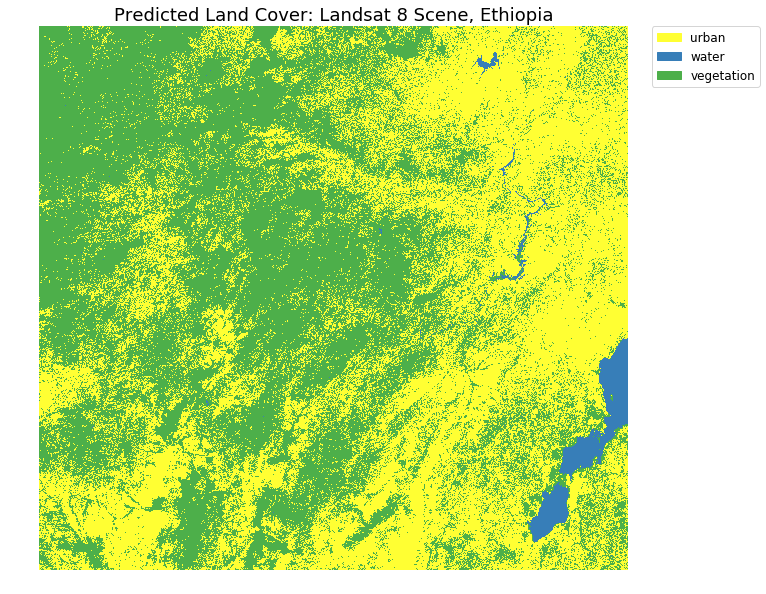

In [50]:
labels = {1: 'urban', 
          2: 'water', 
          3: 'vegetation'}

cols = {1: '#ffff33', 
        2: '#377eb8', 
        3: '#4daf4a'}

cmap = colors.ListedColormap(['#ffff33', '#377eb8', '#4daf4a'])

fig = plt.figure(figsize=(12, 10))
im = plt.imshow(pred_scene, cmap=cmap)
patches = [mpatches.Patch(color=cols[i], label=labels[i]) for i in cols]
plt.legend(handles=patches, bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0., prop={'size':12})
plt.axis('off')
plt.title('Predicted Land Cover: Landsat 8 Scene, Ethiopia', fontsize=18)

plt.savefig('/home/ec2-user/ethiopia_luc/dataset/predicted_scene.png', bbox_inches='tight')